In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

In [2]:
x_train = np.linspace(-3, 3, 10)[:, None]
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=x_train.shape)

In [3]:
class BayesianNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__(
            w1_mu=np.zeros((n_input, n_hidden)),
            w1_s=np.zeros((n_input, n_hidden)),
            b1_mu=np.zeros(n_hidden),
            b1_s=np.zeros(n_hidden),
            w2_mu=np.zeros((n_hidden, n_output)),
            w2_s=np.zeros((n_hidden, n_output)),
            b2_mu=np.zeros(n_output),
            b2_s=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.w1 = bn.random.Gaussian(
            self.w1_mu, bn.softplus(self.w1_s),
            prior=bn.random.Gaussian(0, 1)
        )
        self.b1 = bn.random.Gaussian(
            self.b1_mu, bn.softplus(self.b1_s),
            prior=bn.random.Gaussian(0, 1)
        )
        self.w2 = bn.random.Gaussian(
            self.w2_mu, bn.softplus(self.w2_s),
            prior=bn.random.Gaussian(0, 1)
        )
        self.b2 = bn.random.Gaussian(
            self.b2_mu, bn.softplus(self.b2_s),
            prior=bn.random.Gaussian(0, 1)
        )
        h = bn.tanh(x @ self.w1.draw() + self.b1.draw())
        mu = h @ self.w2.draw() + self.b2.draw()
        self.y = bn.random.Gaussian(mu, 0.1, data=y)
        if y is None:
            return self.y.draw().value

In [4]:
model = BayesianNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for _ in range(10000):
    model.cleargrad()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

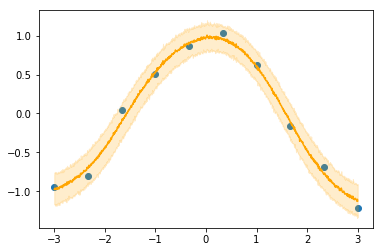

In [5]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
y = [model(x) for _ in range(100)]
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
plt.plot(x, y_mean, c="orange")
plt.fill_between(x.ravel(), (y_mean - y_std).ravel(), (y_mean + y_std).ravel(), color="orange", alpha=0.2)
plt.show()

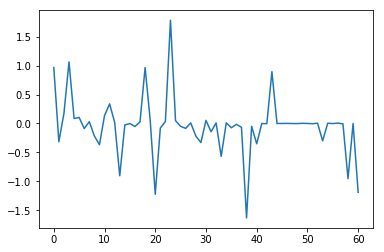

In [6]:
parameter = []
parameter.extend(list(model.w1_mu.value.ravel()))
parameter.extend(list(model.b1_mu.value.ravel()))
parameter.extend(list(model.w2_mu.value.ravel()))
parameter.extend(list(model.b2_mu.value.ravel()))
plt.plot(parameter)

In [7]:
class ARDNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__(
            w1_mu=np.zeros((n_input, n_hidden)),
            w1_s=np.zeros((n_input, n_hidden)),
            rate_w1=np.ones((n_input, n_hidden)),
            b1_mu=np.zeros(n_hidden),
            b1_s=np.zeros(n_hidden),
            rate_b1=np.ones(n_hidden),
            w2_mu=np.zeros((n_hidden, n_output)),
            w2_s=np.zeros((n_hidden, n_output)),
            rate_w2=np.ones((n_hidden, n_output)),
            b2_mu=np.zeros(n_output),
            b2_s=np.zeros(n_output),
            rate_b2=np.ones(n_output)
        )

    def __call__(self, x, y=None):
        tau_w1_prior = bn.random.Exponential(1e-2)
        self.tau_w1 = bn.random.Exponential(bn.softplus(self.rate_w1), prior=tau_w1_prior)
        w1_prior = bn.random.Gaussian(0, var=1 / self.tau_w1.draw())
        self.w1 = bn.random.Gaussian(self.w1_mu, bn.softplus(self.w1_s), prior=w1_prior)

        tau_b1_prior = bn.random.Exponential(1e-2)
        self.tau_b1 = bn.random.Exponential(bn.softplus(self.rate_b1), prior=tau_b1_prior)
        b1_prior = bn.random.Gaussian(0, var=1 / self.tau_b1.draw())
        self.b1 = bn.random.Gaussian(self.b1_mu, bn.softplus(self.b1_s), prior=b1_prior)

        tau_w2_prior = bn.random.Exponential(1e-2)
        self.tau_w2 = bn.random.Exponential(bn.softplus(self.rate_w2), prior=tau_w2_prior)
        w2_prior = bn.random.Gaussian(0, var=1 / self.tau_w2.draw())
        self.w2 = bn.random.Gaussian(self.w2_mu, bn.softplus(self.w2_s), prior=w2_prior)

        tau_b2_prior = bn.random.Exponential(1e-2)
        self.tau_b2 = bn.random.Exponential(bn.softplus(self.rate_b2), prior=tau_b2_prior)
        b2_prior = bn.random.Gaussian(0, var=1 / self.tau_b2.draw())
        self.b2 = bn.random.Gaussian(self.b2_mu, bn.softplus(self.b2_s), prior=b2_prior)

        h = bn.tanh(x @ self.w1.draw() + self.b1.draw())
        mu = h @ self.w2.draw() + self.b2.draw()
        self.y = bn.random.Gaussian(mu, 0.1, data=y)
        if y is None:
            return self.y.draw().value

In [8]:
model = ARDNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)
history = []

for _ in range(10000):
    model.cleargrad()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()
    history.append(elbo.value)

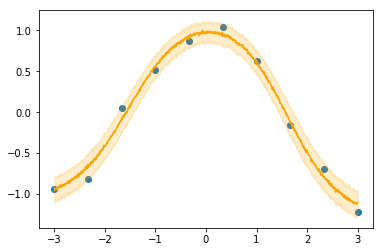

In [9]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
y = [model(x) for _ in range(100)]
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
plt.plot(x, y_mean, c="orange")
plt.fill_between(x.ravel(), (y_mean - y_std).ravel(), (y_mean + y_std).ravel(), color="orange", alpha=0.2)
plt.show()

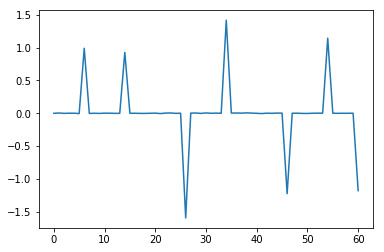

In [10]:
parameter = []
parameter.extend(list(model.w1_mu.value.ravel()))
parameter.extend(list(model.b1_mu.value.ravel()))
parameter.extend(list(model.w2_mu.value.ravel()))
parameter.extend(list(model.b2_mu.value.ravel()))
plt.plot(parameter)